# Information Retrieval using word2vec based Vector Space Model

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import pandas as pd
import re
import sys
sys.path.insert(0, '/home/guinzburg/NLP/Data')
from data_parser import parse_queries, parse_documents, parse_data_ground_truth
from sklearn.model_selection import train_test_split
import spacy ## for stopwords removal
nlp = spacy.load('en_core_web_sm',disable=['ner','parser'])
nlp.max_length=5000000
from gensim.models import Word2Vec # for word2vec model
from sklearn.metrics.pairwise import cosine_similarity

## Word2Vec
Word2vec is a two-layer neural net that processes text by “vectorizing” words. Its input is a text corpus and its output is a set of vectors: feature vectors that represent words in that corpus

## Documents, Queries, and Ground Truth
Load the files containing queries, documents and ground truth using 'parse_queries', 'parse_documents', and parse_data_ground_truth for further processing

In [2]:
# Get all queries
queries = pd.DataFrame.from_dict(parse_queries(path='/home/guinzburg/NLP/Data/CISI.QRY'), columns = ['query'], orient="index")#.reset_index(drop=True)

# Get all documents
documents = pd.DataFrame.from_dict(parse_documents(path='/home/guinzburg/NLP/Data/CISI.ALL'), orient="index").reset_index()
documents.index = range(1, len(documents) + 1)

# Get ground truth
ground_truth = pd.DataFrame.from_dict(parse_data_ground_truth(path='/home/guinzburg/NLP/Data/CISI.REL'), orient='index').T

Create a train set and test set for training the word2vec model for both queries and documents

In [3]:
# Create train and test set for queries (80% / 20%)
training_queries, testing_queries = train_test_split(queries, test_size=0.2)

# Create train and test set for documents (80% / 20%)
training_documents, testing_documents = train_test_split(documents, test_size=0.2)

# Text Preprocessing
Process the documents and queries as follows:

### Documents:
1. Lowercase the text
2. Expand Contractions
3. Clean the text
4. Remove Stopwords
5. Lemmatize words

### Queries:
1. Lowercase the text
2. Expand Contractions
3. Clean the text
4. We now have everything clear in our minds, so let’s start writing codes for pre-processing the documents.

In [5]:
# Create empty corpuses dataframes for training and testing
training_corpus = pd.DataFrame(columns=['cleaned','lemmatized', 'vector'])
testing_corpus = pd.DataFrame(columns=['cleaned','lemmatized', 'vector'])

# Lowercasing the text
training_corpus['cleaned'] = training_documents['body'].apply(lambda x:x.lower())
testing_corpus['cleaned'] = testing_documents['body'].apply(lambda x:x.lower())

def expand_contractions(text):
    """
        Description: function for expanding contractions in a given text
    """
    
    # Dictionary of english Contractions
    contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not","can't": "can not","can't've": "cannot have",
    "'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have",
    "didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
    "hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will",
    "he'll've": "he will have","how'd": "how did","how'd'y": "how do you","how'll": "how will","i'd": "i would",
    "i'd've": "i would have","i'll": "i will","i'll've": "i will have","i'm": "i am","i've": "i have",
    "isn't": "is not","it'd": "it would","it'd've": "it would have","it'll": "it will","it'll've": "it will have",
    "let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
    "mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have",
    "needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
    "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
    "shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will",
    "she'll've": "she will have","should've": "should have","shouldn't": "should not",
    "shouldn't've": "should not have","so've": "so have","that'd": "that would","that'd've": "that would have",
    "there'd": "there would","there'd've": "there would have",
    "they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have",
    "they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we would",
    "we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
    "weren't": "were not","what'll": "what will","what'll've": "what will have","what're": "what are",
    "what've": "what have","when've": "when have","where'd": "where did",
    "where've": "where have","who'll": "who will","who'll've": "who will have","who've": "who have",
    "why've": "why have","will've": "will have","won't": "will not","won't've": "will not have",
    "would've": "would have","wouldn't": "would not","wouldn't've": "would not have","y'all": "you all",
    "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would","you'd've": "you would have","you'll": "you will","you'll've": "you will have",
    "you're": "you are","you've": "you have"}

    # Regular expression for finding contractions
    contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

    def replace(match):
        return contractions_dict[match.group(0)]
    
    return contractions_re.sub(replace, text)

def clean_text(text):
    """
        Description: function for cleaning a given text, 
        such as: 
        [*] remove the words with digits
        [*] replace newline characters with space
        [*] remove URLs
        [*] replace everything that isn’t English alphabets with space
    """
    
    text = re.sub('\w*\d\w*','', text)
    text = re.sub('\n',' ',text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub('[^a-z]',' ',text)
    
    return text

# Expanding Contractions
training_corpus['cleaned'] = training_corpus['cleaned'].apply(lambda x:expand_contractions(x))
testing_corpus['cleaned'] = testing_corpus['cleaned'].apply(lambda x:expand_contractions(x))

# Cleaning corpus using RegEx
training_corpus['cleaned'] = training_corpus['cleaned'].apply(lambda x: clean_text(x))
testing_corpus['cleaned'] = testing_corpus['cleaned'].apply(lambda x: clean_text(x))

# Removing extra spaces
training_corpus['cleaned'] = training_corpus['cleaned'].apply(lambda x: re.sub(' +',' ',x))
testing_corpus['cleaned'] = testing_corpus['cleaned'].apply(lambda x: re.sub(' +',' ',x))

# Removing Stopwords and Lemmatizing words
training_corpus['lemmatized'] = training_corpus['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
testing_corpus['lemmatized'] = testing_corpus['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

Rre-process queries.

In [6]:
# Create empty dataframes for queries training and testing
training_queries_ = pd.DataFrame(columns=['cleaned','lemmatized', 'vector'])
testing_queries_ = pd.DataFrame(columns=['cleaned','lemmatized', 'vector'])

# Lowercasing the text
training_queries_['cleaned'] = training_queries['query'].apply(lambda x:x.lower())
testing_queries_['cleaned'] = testing_queries['query'].apply(lambda x:x.lower())

# Expanding contractions
training_queries_['cleaned'] = training_queries_['cleaned'].apply(lambda x:expand_contractions(x))
testing_queries_['cleaned'] = testing_queries_['cleaned'].apply(lambda x:expand_contractions(x))

# Cleaning queries using RegEx
training_queries_['cleaned'] = training_queries_['cleaned'].apply(lambda x: clean_text(x))
testing_queries_['cleaned'] = testing_queries_['cleaned'].apply(lambda x: clean_text(x))

# Removing extra spaces
training_queries_['cleaned'] = training_queries_['cleaned'].apply(lambda x: re.sub(' +',' ',x))
testing_queries_['cleaned'] = testing_queries_['cleaned'].apply(lambda x: re.sub(' +',' ',x))

# Creating Vectors
Train the word2vec model and generate vectors for documents and queries in the testing set for information retrieval. First step is to prepare the dataset for training the model, and to use the same w2v model for generating vectors for both documents and queries,  we’ll combine both documents and queries training to create a single file

In [7]:
# Combining corpus and queries for training
combined_training = pd.concat([training_corpus.rename(columns={'lemmatized':'text'})['text'],\
                                 training_queries_.rename(columns={'cleaned':'text'})['text']]).sample(frac=1).reset_index(drop=True)

# Model Training
Using Gensim to train the word2vec model. Gensim is a python package used for topic modeling, text processing, and working with word vector models such as Word2Vec and FastText

In [8]:
# Creating data for the model training, iterate on each row from the combined data and split it in to words
train_data = []
for row in combined_training:
    train_data.append(row.split())

# Training a word2vec model from the given data set
# w2v_model = Word2Vec(train_data, vector_size=300, min_count=2, window=5, sg=1, workers=4)
# vector_size: default value 100 [https://stackoverflow.com/questions/45444964/python-what-is-the-size-parameter-in-gensim-word2vec-model-class]
# min_count: Words below the min_count frequency are dropped before training occurs. 
# window: [https://stackoverflow.com/questions/22272370/word2vec-effect-of-window-size-used/30447723#30447723]
w2v_model = Word2Vec(train_data, min_count=2)
print('Vocabulary size:', len(w2v_model.wv.index_to_key))
print('Model vector size:', w2v_model.wv.vector_size)

Vocabulary size: 4011
Model vector size: 100


In [9]:
def get_embedding_w2v(doc_tokens):
    """
    Description: function for generating vectors for the whole document or query. 
    This function will use the word2vec model and generate the vectors for each word in the document.
    Then, it will take the average of the vectors, and the resulting vector will represent the vector for the document. 
    Any document or query of length zero will have a vector containing zeroes, and any word which won’t be present in the vocabulary will have a vector with random values.
    """
    
    embeddings = []
    
    if len(doc_tokens) < 1:
        # w2v_model.wv.vector_size: 100 (default)
        return np.zeros(w2v_model.wv.vector_size)
    else:
        for tok in doc_tokens:
            if tok in list(w2v_model.wv.index_to_key):
                embeddings.append(w2v_model.wv.get_vector(tok))
            else:
                # w2v_model.wv.vector_size: 100 (default)
                embeddings.append(np.random.rand(w2v_model.wv.vector_size))
    
        # mean the vectors of individual words to get the vector of the document
        return np.mean(embeddings, axis=0)

# Getting Word2Vec Vectors for Testing Corpus and Queries
testing_corpus['vector'] = testing_corpus['lemmatized'].apply(lambda x :get_embedding_w2v(x.split()))
testing_queries_['vector'] = testing_queries_['cleaned'].apply(lambda x :get_embedding_w2v(x.split()))

# Final IR Pipeline

In [10]:
def ranking_ir(query):
    """
        Description: a function that takes a query as an input and return the top 10 relevant documents. 
        This function will follow the information retrieval(IR) pipeline. First, it will pre-process the query. Then, it will generate the vector for it. After that, it will rank the documents based on the similarity scores.
    """      
    # pre-process Query
    query = re.sub(' +', ' ', clean_text(expand_contractions(query.lower())))

    # generating vector
    vector = get_embedding_w2v(query.split())

    # ranking documents
    documents_ = documents[['index', 'title','body']].copy()
    documents_['similarity'] = testing_corpus['vector'].apply(lambda x: cosine_similarity(np.array(vector).reshape(1, -1),np.array(x).reshape(1, -1)).item())
    documents_.sort_values(by='similarity', ascending=False, inplace=True)

    return documents_.head(10).reset_index(drop=True)

## Precision and Recall
#### Precision
Precision measures "of all the documents we retrieved as relevant how many are actually relevant?"
Precision = No. of relevant documents retrieved / No. of total documents retrieved<br><br>
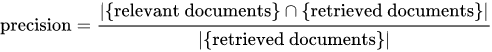
#### Recall
Recall is the fraction of the documents that are relevant to the query that are successfully retrieved
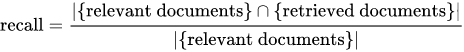

# Testing

In [11]:
# Calcualte precision and recall for each query using ground truth
def common(a, b): 
    c = [value for value in a if value in b] 
    return c

queries_response = {}
for i in range(0, len(queries)):
    
    try:
        # Get dll documents ID's 
        retrived_documents = [doc_id for doc_id in ranking_ir(queries.iloc[[i]]['query'].values[0])['index']]
        # Get all relevant documents and ignore 'None' values
        relevant_documents = [doc_id for doc_id in ground_truth[f"{i+1}"] if doc_id] # get
        # Get commong documents ID's
        c = common(relevant_documents, retrived_documents)
        # Calculate Precision
        precision = len(c) / len(retrived_documents)
        # Calcualte Recall
        recall = len(c) / len(relevant_documents)
        
    except KeyError:
        # When there's no relevant document, precision and recall should be 0
        precision = recall = 0

    queries_response[i+1] = {"query": queries.iloc[[i]]['query'],
                             "relevant_documents": relevant_documents, 
                             "retrived_documents": retrived_documents,
                             "precision": precision,
                             "recall": recall}   

In [12]:
q_id = 50
print(f"Query ID {q_id}:", queries_response[q_id]['query'].values[0]) 
relevant_docs = queries_response[q_id]['relevant_documents']
print("Relevant Documents:", relevant_docs)
retrived_docs = queries_response[q_id]['retrived_documents']
print("Retrived Documents:", retrived_docs)
print("Precision:",queries_response[q_id]["precision"])
print("Recall:", queries_response[q_id]["recall"])

Query ID 50: Is there any use for traditional classification schemes - DDC, UDC, LC, etc. - in information retrieval systems? If there is, which scheme appears most suited to machine use and where has it been applied? If there is not, why are these classification schemes irrelevant? Has research shown that a subject classification of knowledge is completely unnecessary in machine systems? Or, have new schemes been devised which appear to be more suited to machine use?
Relevant Documents: ['1', '16', '45', '80', '154', '209', '257', '258', '259', '260', '262', '263', '275', '276', '333', '334', '335', '342', '354', '361', '388', '404', '480', '488', '522', '527', '530', '564', '576', '596', '608', '701', '702', '758', '769', '797', '801', '817', '820', '825', '830', '838', '853', '868', '869', '884', '898', '931', '960', '966', '989', '993', '996', '999', '1010', '1066', '1072', '1074', '1075', '1103', '1137', '1140', '1141', '1170', '1202', '1215', '1216', '1230', '1231', '1259', '1265

In [13]:
# Calcualte average Precision and Recall
sum_precision = sum_recall = 0
for q_id in queries_response:
    sum_precision += queries_response[q_id]["precision"]
    sum_recall += queries_response[q_id]["recall"]
print("Average Precision:", sum_precision / int(q_id))
print("Average Precision:", sum_recall / int(q_id))

Average Precision: 0.019642857142857146
Average Precision: 0.004577859662858973
